## 지금까지 했던 걸로 GMEAN 해 보기
- [GMEAN of low correlation (LB: 0.952x)](https://www.kaggle.com/paulorzp/gmean-of-low-correlation-lb-0-952x)
- 결과: 0.9476. single model로 가장 높았던 것과 같음.
- correlation이 너무 높은 결과들을 묶음
- single model 더 만들어 보기

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob

from scipy.stats import describe
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
LABELS = ["isFraud"]
all_files = glob.glob("*.csv")
all_files

['0902_submission.csv',
 '0904_allfeature_submission.csv',
 '0910_submission.csv',
 '0916_top50_submission.csv',
 '0917_submission.csv',
 'feature_importances.csv',
 'feature_importances_new.csv',
 'first_submission.csv',
 'gb2_submission.csv',
 'stack_gmean.csv',
 'submission.csv',
 'xgver_submission.csv']

In [3]:
top_list = ['0902_submission.csv', #0.9447
            '0904_allfeature_submission.csv', #0.9453
            '0910_submission.csv', #0.9461
            '0917_submission.csv', #0.9476
            'gb2_submission.csv'] #0.9351
scores = [0.9447, 0.9453, 0.9461, 9476, 9351]

In [4]:
outs = [pd.read_csv(file, index_col = 0) for file in top_list]
concat_sub = pd.concat(outs, axis = 1)

In [5]:
cols = list(map(lambda x: "m" + str(x), range(len(concat_sub.columns))))
concat_sub.columns = cols

In [6]:
corr = concat_sub.corr()
np.zeros_like(corr, dtype=np.bool)

array([[False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False]])

In [7]:
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
mask

array([[ True,  True,  True,  True,  True],
       [False,  True,  True,  True,  True],
       [False, False,  True,  True,  True],
       [False, False, False,  True,  True],
       [False, False, False, False,  True]])

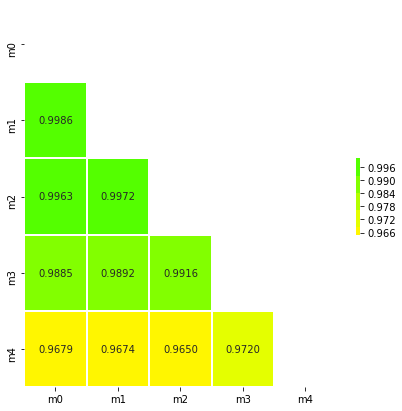

In [8]:
f, ax = plt.subplots(figsize = (len(cols) + 2, len(cols) + 2))
sns.heatmap(corr, mask = mask, cmap='prism', center=0, linewidths=1,
           annot=True, fmt='.4f', cbar_kws={"shrink": .2})

In [9]:
# 원래 코드에선 corr 가장 낮은 6개를 추림.
mean_corr = corr.mean().sort_values(ascending = True)
mean_corr

m4    0.974469
m3    0.988250
m2    0.990026
m0    0.990235
m1    0.990475
dtype: float64

### Gmean of models with low average correlation

In [10]:
m_gmean1 = 0
for n in mean_corr.index:
    m_gmean1 += np.log(concat_sub[n])
m_gmean1 = np.exp(m_gmean1 / len(mean_corr))

In [11]:
rank = np.tril(corr.values, -1)
rank[rank < 0.92] = 1
m = (rank > 0).sum() - (rank > 0.97).sum()
m

3

In [12]:
m_gmean2, s = 0, 0
for n in range(m):
    mx = np.unravel_index(rank.argmin(), rank.shape)
    w = (m - n) / m
    m_gmean2 += w * (np.log(concat_sub.iloc[:, mx[0]]) + np.log(
    concat_sub.iloc[:, mx[1]])) /2
    s += w
    rank[mx] = 1
m_gmean2 = np.exp(m_gmean2 / s)

## Top Blends weighted by score

In [13]:
top_mean = 0
s = 0
for n in range(concat_sub.shape[1]):
    # 1. 각 열의 데이터(각 submission 결과)에 score를 곱함. 왜??
    top_mean += concat_sub.iloc[:, n] * scores[n]
    # 2. score들의 합
    s += scores[n]
top_mean /= s

In [14]:
top_mean.describe()

count    506691.000000
mean          0.025508
std           0.114004
min           0.000151
25%           0.001355
50%           0.003033
75%           0.008117
max           0.998107
Name: m0, dtype: float64

### GMEAN final stacking

In [15]:
# 0.3, 0.2, 0.5 계수들은 무엇??
m_gmean = np.exp(0.3 * np.log(m_gmean1) + 0.2 * np.log(m_gmean2) + \
                0.5 * np.log(top_mean))
describe(m_gmean)

DescribeResult(nobs=506691, minmax=(0.0001429181409458463, 0.998110480577958), mean=0.024681324412131264, variance=0.012787822938357825, skewness=7.12431831206762, kurtosis=52.30012771252893)

In [16]:
concat_sub['isFraud'] = m_gmean
concat_sub[['isFraud']].to_csv('stack_gmean.csv')
#이렇게 해야 index(TransactionID) 까지 저장됨!! 참고해 두기

In [19]:
concat_sub[['isFraud']].head()

,isFraud
TransactionID,
3663549,0.000941
3663550,0.001438
3663551,0.001765
3663552,0.001218
3663553,0.001334


In [21]:
outs[3].head()

,isFraud
TransactionID,
3663549,0.000280
3663550,0.000618
3663551,0.000847
3663552,0.000660
3663553,0.000621


In [33]:
concat_sub.corr()

,m0,m1,m2,m3,m4,isFraud
m0,1.000000,0.998561,0.996286,0.988454,0.967875,0.992012
m1,0.998561,1.000000,0.997231,0.989189,0.967395,0.992255
m2,0.996286,0.997231,1.000000,0.991573,0.965039,0.991964
m3,0.988454,0.989189,0.991573,1.000000,0.972036,0.994634
m4,0.967875,0.967395,0.965039,0.972036,1.000000,0.988267
isFraud,0.992012,0.992255,0.991964,0.994634,0.988267,1.000000
